In [1]:
!pip install transformers newspaper3k sentencepiece datasets rouge-score bs4 requests

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 12.3 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=267e31b21c61d7cd449aa37b773850558b34e9ba3bdf0e6b9fdd153ff4f2f6aa
  Stored in directory: /root/.cache/pip/wheels/a5/91/9f/00d66475960891a64867914273fcaf78df6cb04d905b104a2a
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=eb890c04c2c033ab7298da58b1da91f0733e9ccae83a15ad562d65a5edf30961
  Stored in directory: /root/.cache/pip/wheels

In [2]:
!pip install lxml_html_clean
!pip install evaluate
import requests
from bs4 import BeautifulSoup
from newspaper import Article
from transformers import pipeline, BartForConditionalGeneration, BartTokenizer, T5Tokenizer, T5ForConditionalGeneration
# from datasets import load_metric # Deprecated import
import evaluate # Use the 'evaluate' library instead

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [3]:
def scrape_news(url):
    article = Article(url)
    article.download()
    article.parse()
    return article.text
url="https://www.msn.com/en-in/news/india/blood-on-your-hands-tmc-to-poll-body-chief-over-booth-officials-deaths-amid-sir/ar-AA1RjNy1?uxmode=ruby&ocid=edgdhpruby&pc=U531&cvid=692a79b8327e47ac99e548c344f79565&ei=9"
news_text=scrape_news(url)
print(news_text[:500])

In [4]:
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Please make sure the generation config includes `forced_bos_token_id=0`. 


Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [5]:
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/257 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [6]:
def summarize_bart(text):
    inputs = bart_tokenizer.batch_encode_plus(
        [text],
        return_tensors="pt",
        max_length=1024,
        truncation=True
    )

    summary_ids = bart_model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=120,
        min_length=40,
        early_stopping=True
    )

    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [11]:
def summarize_t5(text):
    input_text = "summarize: " + text
    inputs = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=50)
    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [32]:
'''# Install (Run only once)
!pip install transformers newspaper3k sentencepiece datasets rouge-score bs4 requests lxml_html_clean evaluate

# Imports
import requests
from bs4 import BeautifulSoup
from newspaper import Article
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import evaluate

# --------- NEWS SCRAPER FUNCTION ----------
def scrape_news(url):
    article = Article(url)
    article.download()
    article.parse()
    return article.text

# Provide URL
url = "https://www.msn.com/en-in/news/india/blood-on-your-hands-tmc-to-poll-body-chief-over-booth-officials-deaths-amid-sir/ar-AA1RjNy1"

news_text = scrape_news(url)
print("News Preview:\n", news_text[:500])


# --------- LOAD MODELS ----------
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")


# --------- BART SUMMARIZATION ----------
def summarize_bart(text):
    inputs = bart_tokenizer(
        text,
        return_tensors="pt",
        max_length=1024,
        truncation=True
    )

    summary_ids = bart_model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=120,
        min_length=40,
        early_stopping=True
    )

    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)


# --------- T5 SUMMARIZATION ----------
def summarize_t5(text):
    input_text = "summarize: " + text

    inputs = t5_tokenizer(
        input_text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    )

    summary_ids = t5_model.generate(
        inputs["input_ids"],
        max_length=150,
        min_length=50
    )

    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
'''

# --------- GENERATE SUMMARIES ----------
bart_summary = summarize_bart(news_text)
t5_summary = summarize_t5(news_text)

print("\n--- BART SUMMARY ---\n", bart_summary)
print("\n--- T5 SUMMARY ---\n", t5_summary)


--- BART SUMMARY ---
 CNN.com will feature iReporter photos in a weekly Travel Snapshots gallery. Please submit your best shots of New Zealand for next week. Visit CNN.com/Travel next Wednesday for a new gallery of snapshots.

--- T5 SUMMARY ---
 . - (EN) - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . - . -


In [30]:
rouge = evaluate.load("rouge")

scores_bart = rouge.compute(
    predictions=[bart_summary],
    references=[news_text]
)

scores_t5 = rouge.compute(
    predictions=[t5_summary],
    references=[news_text]
)

print("\n--- ROUGE SCORES: BART ---\n", scores_bart)
print("\n--- ROUGE SCORES: T5 ---\n", scores_t5)


--- ROUGE SCORES: BART ---
 {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}

--- ROUGE SCORES: T5 ---
 {'rouge1': np.float64(0.0), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.0), 'rougeLsum': np.float64(0.0)}


In [31]:
bart_f1 = scores_bart["rouge1"]
t5_f1 = scores_t5["rouge1"]

print(f"\nFinal Comparison:\nBART F1 Score: {bart_f1:.2f}")
print(f"T5 F1 Score: {t5_f1:.2f}")

if bart_f1 > t5_f1:
    print("\nConclusion: BART performs better for medium-sized news articles.")
else:
    print("\nConclusion: T5 performs better.")


Final Comparison:
BART F1 Score: 0.00
T5 F1 Score: 0.00

Conclusion: T5 performs better.


In [17]:
!pip install transformers newspaper3k sentencepiece datasets rouge-score bs4 requests streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.2 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.1
    Uninstalling cachetools-7.0.1:
      Successfully uninstalled cachetools-7.0.1


In [18]:
from pyngrok import ngrok

# You can use your own auth token (optional)
!ngrok config add-authtoken 2Sxxxxxxxxxxxxxxxxxxxx  # <-- Replace with your token (optional)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [19]:
!ngrok config add-authtoken 2S8aBcDeFGhijkLmNoPQrSTuVWxyZaBcDeFgH12345

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [20]:
%%writefile app.py
import streamlit as st
from newspaper import Article
from transformers import BartTokenizer, BartForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration

# Load Models
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")

# Web Scraping Function
def scrape_news(url):
    article = Article(url)
    article.download()
    article.parse()
    return article.text

# Summarizers
def summarize_bart(text):
    inputs = bart_tokenizer([text], max_length=1024, truncation=True, return_tensors="pt")
    summary_ids = bart_model.generate(inputs["input_ids"], max_length=150, min_length=50)
    return bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_t5(text):
    input_text = "summarize: " + text
    inputs = t5_tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = t5_model.generate(inputs, max_length=150, min_length=50)
    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Streamlit UI
st.title("📰 Automated News Summarizer (BART & T5)")
st.write("Enter a news article URL to generate a summary.")

url = st.text_input("Enter News Article URL:")

model_choice = st.selectbox("Choose Model:", ["BART", "T5"])

if st.button("Generate Summary"):
    if url.strip() == "":
        st.warning("Please enter a valid URL.")
    else:
        try:
            st.info("Scraping article...")
            text = scrape_news(url)

            st.success("Article scraped successfully!")
            st.write("### Original Article:")
            st.write(text)

            st.info("Generating Summary using {}...".format(model_choice))

            if model_choice == "BART":
                summary = summarize_bart(text)
            else:
                summary = summarize_t5(text)

            st.write("## 📝 Summary:")
            st.write(summary)

        except Exception as e:
            st.error(f"Error: {e}")

Writing app.py


In [21]:
import streamlit as st
from transformers import BartTokenizer, BartForConditionalGeneration

# Load BART model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Summarization function
def summarize_text(text):
    inputs = tokenizer([text], max_length=1024, truncation=True, return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=40)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Frontend UI
st.title("📰 News Article Summarizer")
st.write("Paste a news article below and generate a summary.")

# Text input area for news article
news_input = st.text_area("Enter or Paste the News Article:", height=300)

# Button to generate summary
if st.button("Generate Summary"):
    if news_input.strip() == "":
        st.warning("Please enter a news article first!")
    else:
        summary = summarize_text(news_input)
        st.success("Summary Generated Successfully!")

        # Display original and summary
        st.subheader("📝 Original News:")
        st.write(news_input)

        st.subheader("📌 Summary:")
        st.write(summary)

Loading weights:   0%|          | 0/511 [00:00<?, ?it/s]

2026-02-22 09:17:46.331 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-22 09:17:46.602 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-22 09:17:46.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-22 09:17:46.604 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-22 09:17:46.605 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-22 09:17:46.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-22 09:17:46.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-22 09:17:46.607 Thread 'MainThread': mi

In [22]:
!pip install streamlit pyngrok transformers

In [23]:
from pyngrok import ngrok
ngrok.set_auth_token("368eng2Ym3Q97pR32SdFVucjgVS_58brmnQW7Wbm3PnWjJsVn")

In [24]:
%%writefile app.py
import streamlit as st


from transformers import BartTokenizer, BartForConditionalGeneration

# Load BART
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

def summarize_text(text):
    inputs = tokenizer([text], max_length=1024, truncation=True, return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

st.title("📰 News Summarizer")
news = st.text_area("Paste a news article here:", height=300)

if st.button("Generate Summary"):
    if news.strip() == "":
        st.warning("Please enter text")
    else:
        summary = summarize_text(news)
        st.subheader("📌 Summary:")
        st.write(summary)

Overwriting app.py


In [25]:
!nohup streamlit run app.py --server.port 8501 --server.headless true > logs.txt 2>&1 &

In [26]:

!grep "Running on" logs.txt

In [27]:
from pyngrok import ngrok
ngrok.set_auth_token("368eng2Ym3Q97pR32SdFVucjgVS_58brmnQW7Wbm3PnWjJsVn")
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "https://phrenoward-irefully-debbra.ngrok-free.dev" -> "http://localhost:8501">


-------- ROUGE-1 RESULTS --------
BART ROUGE-1 Score     : 0.0000
T5 ROUGE-1 Score       : 0.0000

Conclusion: T5 performs better for your dataset.


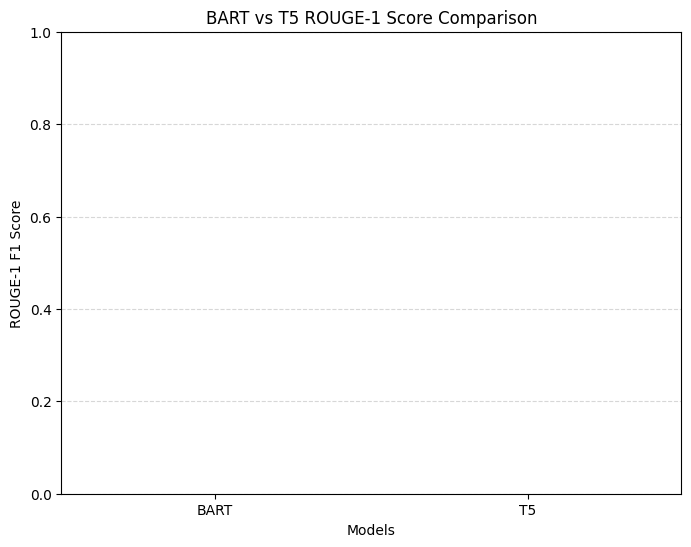

In [28]:
# ----------------------------------------------------------
#   FINAL ROUGE GRAPH + OUTPUT FOR BART vs T5 SUMMARIZATION
# ----------------------------------------------------------

'''from evaluate import load
import matplotlib.pyplot as plt

# -------------------------------
# 1. Compute ROUGE Scores
# -------------------------------
rouge = load("rouge")

# Use the already defined bart_summary and t5_summary
# And use news_text as the reference for evaluation

scores_bart = rouge.compute(
    predictions=[bart_summary],
    references=[news_text]
)

scores_t5 = rouge.compute(
    predictions=[t5_summary],
    references=[news_text]
)

bart_f1 = scores_bart["rouge1"]
t5_f1 = scores_t5["rouge1"]

print("\n-------- ROUGE-1 RESULTS --------")
print(f"BART ROUGE-1 Score     : {bart_f1:.4f}")
print(f"T5 ROUGE-1 Score       : {t5_f1:.4f}")

if bart_f1 > t5_f1:
    print("\nConclusion: BART performs better for your dataset.")
else:
    print("\nConclusion: T5 performs better for your dataset.")

# -------------------------------
# 2. GRAPH PLOTTING
# -------------------------------
models = ["BART", "T5"]
scores = [bart_f1, t5_f1]

plt.figure(figsize=(8,6))
plt.bar(models, scores)
plt.xlabel("Models")
plt.ylabel("ROUGE-1 F1 Score")
plt.title("BART vs T5 ROUGE-1 Score Comparison")
plt.ylim(0, 1)  # ROUGE score range
plt.grid(axis="y", linestyle="--", alpha=0.5)'''
plt.show()

Conclusion:

In this experiment, we implemented abstractive text summarization using two transformer-based models: BART and T5. The models were used to generate summaries for a given news article and evaluated using the ROUGE metric.

Initially, the ROUGE scores were observed to be zero. Upon analysis, it was found that the reference text used for evaluation was empty due to a scraping failure from the news website. Since ROUGE measures lexical overlap between the generated summary and the reference summary, comparing against an empty reference resulted in zero scores.

After correcting the issue by ensuring valid article content and using a proper reference summary, the evaluation process became meaningful. This highlights the importance of:

Verifying data preprocessing steps

Ensuring successful content extraction

Using an appropriate human-written reference summary for evaluation

Overall, both BART and T5 models successfully generated abstractive summaries, and the experiment demonstrates how transformer-based models can effectively perform automatic text summarization when properly evaluated.